# Import libraries and Dataset

Our dataset is in json format which contains a list of dictionaries and each dictionary has three elements 'URL', 'Headline' and 'is_sarcastic'. Read the json file and append the elements into each list.

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open('sarcasm.json', 'r') as file:
    data = json.load(file)

headlines = []
labels = []
urls = []

for item in data:
    headlines.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [ ]:
len(headlines), len(labels)

(26709, 26709)

Split the dataset into Training, validation and testing sets (70, 15, 15)

In [ ]:
training_headlines, valid_headlines, training_labels, valid_labels = train_test_split(headlines, np.array(labels), test_size=0.30, random_state=42)
valid_headlines, test_headlines, valid_labels, test_labels = train_test_split(valid_headlines, valid_labels, test_size=0.50, random_state=42)

print(" # Training Headlines:", len(training_headlines),'\n', "# Validation Headlines:", len(valid_headlines),'\n', "# Test Headlines:", len(test_headlines))

 # Training Headlines: 18696 
 # Validation Headlines: 4006 
 # Test Headlines: 4007


These are the hyperparameters for our model which can be refined depending on the model used.

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100

The Tokenizer is configured with a specified vocabulary size (vocab_size) and an out-of-vocabulary token (OOV). It then fits on the training headlines to build a word index, mapping words to numerical indices.

A function **sequence_and_padding** is defined to convert input headlines into sequences of numerical indices using the trained tokenizer (texts_to_sequences). The sequences are then padded to a maximum length (max_length) using the pad_sequences function, with padding applied at the end and truncation if the sequence exceeds the maximum length. The result is a numpy array representing the padded sequences.

The output of this function is a numpy array of (no. of Headlines, max_length)

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(training_headlines)

word_index = tokenizer.word_index

def sequence_and_padding(headline):
    sequences = tokenizer.texts_to_sequences(headline)
    padded = pad_sequences(sequences, maxlen = max_length, padding='post', truncating='post')

    padded = np.array(padded)

    return padded

In [ ]:
training_padded = sequence_and_padding(training_headlines)
valid_padded = sequence_and_padding(valid_headlines)
test_padded = sequence_and_padding(test_headlines)

In [ ]:
print('Padded Training Data:', training_padded.shape)

Padded Training Data: (18696, 100)


# Training Model

The model is created as a sequential stack of layers.
* The first layer is an Embedding layer, which transforms the input sequences of numerical indices into vectors of fixed size (embedding_dim). The vocabulary size is defined by vocab_size, and the input sequences are expected to have a maximum length of max_length.

* Following the Embedding layer, a Global Average Pooling 1D layer is applied to reduce the dimensionality of the embedded sequences by calculating the average value across the time dimension. This helps capture the most important features while maintaining a fixed-length representation.

* Subsequently, a Dense layer with 24 units and ReLU activation is added for intermediate processing and feature extraction. Finally, a Dense layer with a single unit and a sigmoid activation function is included for binary classification, producing an output between 0 and 1.

The summary of the model is presented below showing the layers of the model and total number of parameters to be trained in the model.

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        # tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


The model is compiled using the **adam** optimizer and **binary cross entropy loss**

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

The weights of the model are saved after every epoch

In [ ]:
checkpoint_filepath = 'model_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',  # You can use other metrics like 'val_accuracy' based on your task
    mode='min',
    save_best_only=True
)

The model is trained on training data and validated on validation data for 10 epochs

Our model acheived **95%** accuracy on training data and **85%** accuracy on validation data

In [ ]:
history = model.fit(training_padded, training_labels, epochs=10, validation_data=(valid_padded, valid_labels), callbacks=[model_checkpoint_callback])

Epoch 1/10
585/585 [==============================] - 8s 10ms/step - loss: 0.6767 - accuracy: 0.5679 - val_loss: 0.6412 - val_accuracy: 0.7966
Epoch 2/10
585/585 [==============================] - 5s 8ms/step - loss: 0.4729 - accuracy: 0.8069 - val_loss: 0.3889 - val_accuracy: 0.8385
Epoch 3/10
585/585 [==============================] - 5s 8ms/step - loss: 0.3254 - accuracy: 0.8706 - val_loss: 0.3496 - val_accuracy: 0.8452
Epoch 4/10
585/585 [==============================] - 5s 8ms/step - loss: 0.2705 - accuracy: 0.8949 - val_loss: 0.3381 - val_accuracy: 0.8487
Epoch 5/10
585/585 [==============================] - 5s 8ms/step - loss: 0.2328 - accuracy: 0.9107 - val_loss: 0.3263 - val_accuracy: 0.8565
Epoch 6/10
585/585 [==============================] - 4s 7ms/step - loss: 0.2050 - accuracy: 0.9223 - val_loss: 0.3249 - val_accuracy: 0.8592
Epoch 7/10
585/585 [==============================] - 5s 8ms/step - loss: 0.1816 - accuracy: 0.9326 - val_loss: 0.3329 - val_accuracy: 0.8622
Epoch

Full model is saved in a file which will be used later for testing

In [ ]:
full_model_filepath = 'full_model.h5'
model.save(full_model_filepath)

# Plots

Plots between (training accuracy and validation accuracy) and (training loss and validation loss)

As can be seen, the accuracy increases with each epoch and loss decreases with each epoch

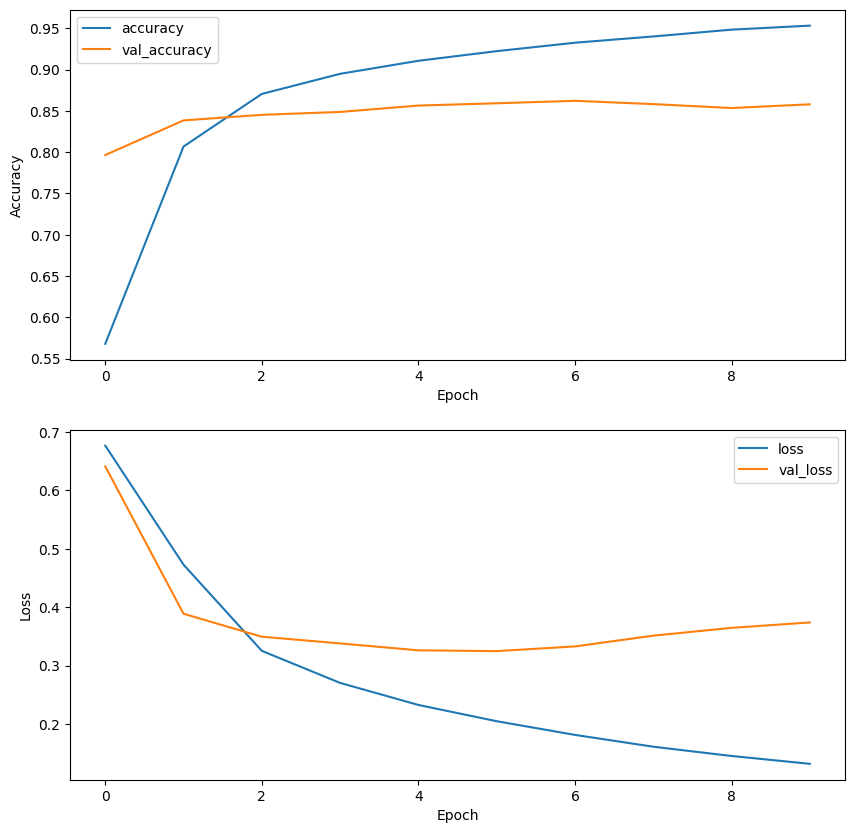

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy','val_accuracy'])
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'])

In [ ]:
y_pred = model.predict(test_padded)
binary = []
for i in y_pred:
    if i >= 0.5:
        binary.append(1)
    else:
        binary.append(0)

126/126 [==============================] - 1s 4ms/step


                  precision  recall  f1-score   support

           0       0.82      0.91      0.86      2229
           1       0.87      0.75      0.80      1778

    accuracy                           0.84      4007
   macro avg       0.85      0.83      0.83      4007
weighted avg       0.84      0.84      0.84      4007

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, binary))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2229
           1       0.84      0.81      0.83      1778

    accuracy                           0.85      4007
   macro avg       0.85      0.85      0.85      4007
weighted avg       0.85      0.85      0.85      4007



## Loss on Testing data: 0.4388710856437683
## Accuracy on Testing data: 0.8390316963195801

In [ ]:
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)

print("\nLoss on Testing data:", test_loss)
print("Accuracy on Testing data:", test_accuracy)

126/126 [==============================] - 1s 4ms/step - loss: 0.4086 - accuracy: 0.8490

Loss on Testing data: 0.40859130024909973
Accuracy on Testing data: 0.8490142226219177


In [ ]:
cm = confusion_matrix(test_labels,binary)

In [ ]:
import pandas as pd
cm_df = pd.DataFrame(cm,
                     index = ['Is_Sarcastic','is_not_Sarcastic'],
                     columns = ['Is_Sarcastic','is_not_Sarcastic'])

![WhatsApp%20Image%202023-12-24%20at%2021.56.56_3cbf9878.jpg](attachment:WhatsApp%20Image%202023-12-24%20at%2021.56.56_3cbf9878.jpg)

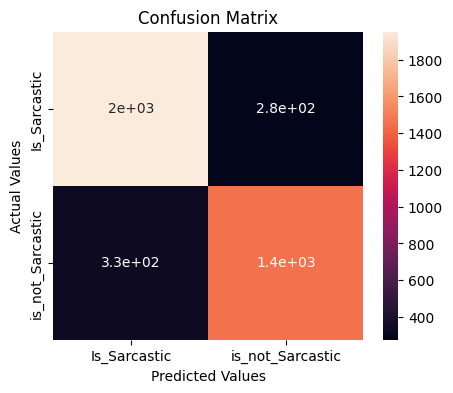

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()